# Introduction

---

This notebook is intended to give *some* insight as to which volume layers (0-64) show promise for use in our networks, and what kind of normalization techniques could be helpful. I also comment on the similarities and differences between the volumes. All of this is accomplished by showing various volume statistics of the voxel Intensity values. These Intensity values range between 0-65535 due to the range of dtype uint16. I show both "bulk" volume statistics and layer by layer statistics.

### Summary of promising volume layers

This section is highly influenced by the following plots, which were taken from the "Layer-by-Layer Statistics" section from each of the three training volumes. Of note, the "Ink Labels" line is computed over only the ink labels, and "Intersection" is computed over all but the ink labels. Therefore, these are the two curves to pay special attention to.

Train Volume 1


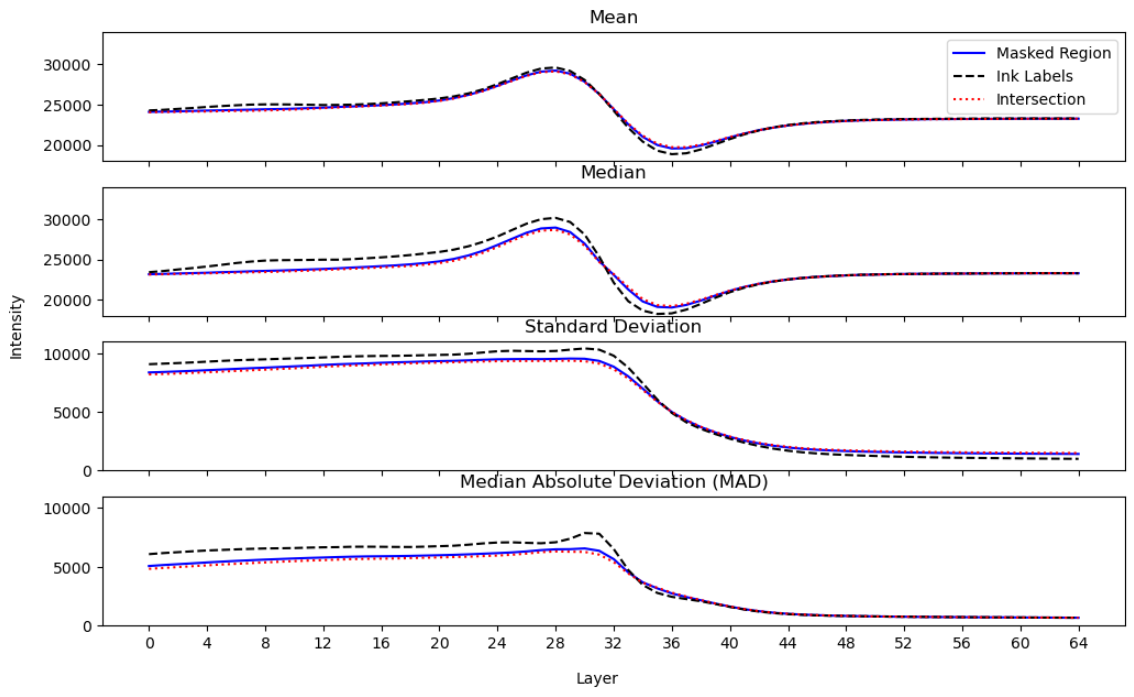


Train Volume 2


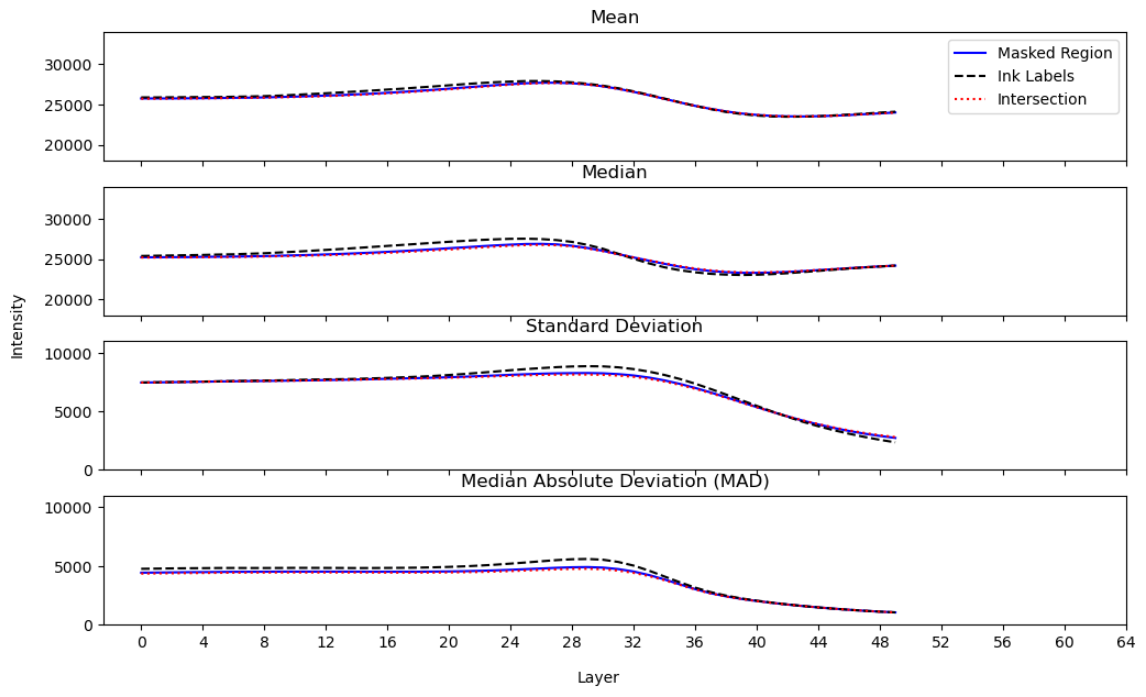


Train Volume 3

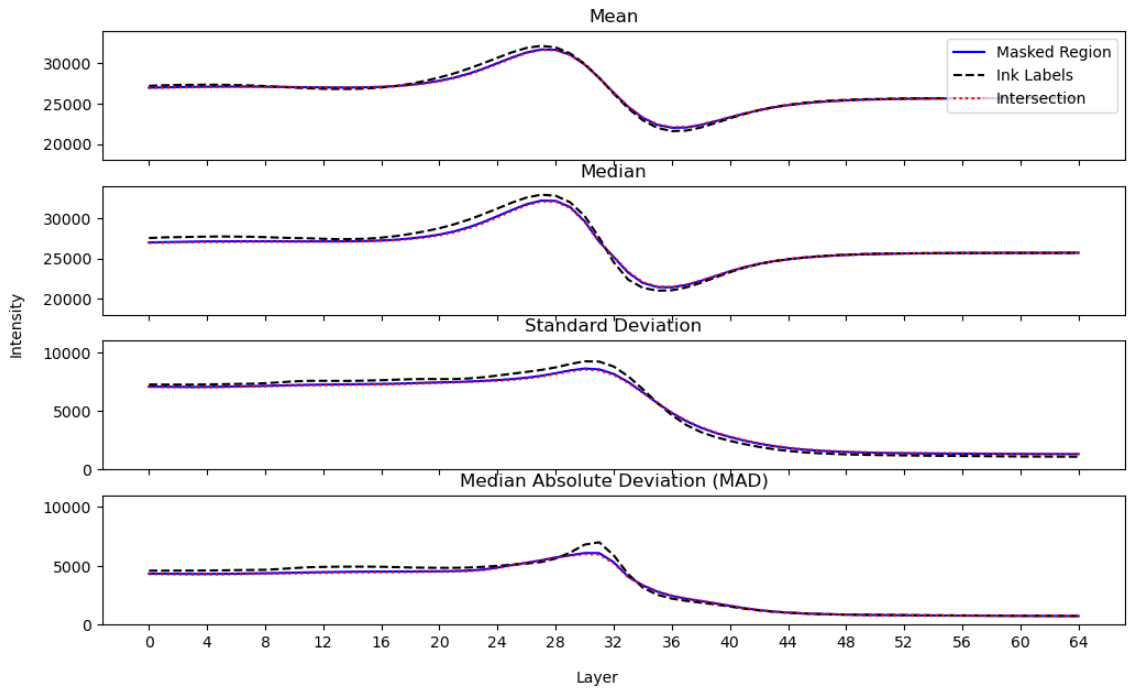


To make a long explanation short, the layers yielding the best performance will likely be the regimes in the above plots where the "Ink Labels" and "Intersection" curves are most different. Furthermore, accross all three volumes, the Median and MAD (as opposed to Mean and Standard Deviation) plots show the greatest degree of distinction between these two curves. ***Therefore, my recommendation is to use a Median Normalization approach and to target the layers that show the greatest difference between these curves.***

Furthermore, it may be worth stacking non-sequential layers (e.g. layers 13-22 + layers 26-36). This is motivated by what is observed in the Volume 2 plot above, wherein the regimes of greatest difference for the Median and MAD do not entirely overlap. This approach may also help to compensate for the fact that the regimes of greatest difference are not always the same for each volume.

*Aside: It is worth noting that volumes 1 & 3 appear to have a similar distribution of voxel intensities through the volumes thickness. Volume 2 deviates from these, indicating that Volume 2 will be a helpful set that imposes a regularizing effect on model performance. Test volumes a & b are simply subsets of volume 1, and therefore have similar distributions to volumes 1 & 3.*

### Normalization Recomendations

As far as normalization goes, the standard technique is to either import the raw data as uint16 and divide by 65535, or as uint8 and divide by 255. The first is Min-Max normalization in one step, and the second is Min-Max normalization in two steps - if the default behaviour is employed. However, Min-Max normalization may not be the optimal approach for this dataset since the data is not uniformly distributed. See [this tutorial](https://developers.google.com/machine-learning/data-prep/transform/normalization) for more information.

normalization recommendations:
* As mentioned in the section above, I believe the use of a Median Normalization approach is promising. This is in part inspired by the presence of large outliers within the volume. Furthermore, the Ink Labels are more distinct in their Median/MAD plots as opposed to their Mean/Standard Deviation plots. Median Normalization, as opposed to Mean Normalization, is ideal for these reasons. The equation for Median Normalization is as follows: $$x'=\frac{(x-median(x))}{MAD(x)}$$ where MAD is the "Median Absolute Deviation." Whether it is best to carry out this normalization Layer-by-Layer or accross the whole selection of layers is unknown.

* Use of Feature Clipping may also be helpful in aiding feature recognition (min = ~10,000; max = ~50,000). However, this will simply shift the outliers toward the center of the distribution. One might consider using Feature Clipping, followed by Median Normalization.

## Mentions

Grateful to both [FCHOLLET](https://www.kaggle.com/fchollet) and [LEONID KULYK](https://www.kaggle.com/leonidkulyk)

Check out their particular notebooks that were helpful and inspiring to me:
* FCHOLLET: https://www.kaggle.com/code/fchollet/a-simple-high-performance-tf-data-pipeline
* LEONID KULYK: https://www.kaggle.com/code/leonidkulyk/eda-vc-id-volume-layers-animation

# Imports and Function Definitions

In [ ]:
import numpy as np

import gc
from tqdm import tqdm
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import pandas as pd
import PIL.Image as Image
import copy

try:
    from celluloid import Camera
except:
    !pip install celluloid -q
    from celluloid import Camera


DATA_DIR = "/kaggle/input/vesuvius-challenge-ink-detection"
Z_DIM = 65   # Number of slices in the z direction. Max value is 65 - Z_START
Z_START = 0  # Offset of slices in the z direction

#### Define data loading functions

In [ ]:
def load_mask(split, index):
    img = Image.open(f"{DATA_DIR}/{split}/{index}/mask.png")
    img = np.array(img, dtype='bool')
    return img

def load_ink_mask(split, index):
    img = Image.open(f"{DATA_DIR}/{split}/{index}/inklabels.png")
    img = np.array(img, dtype='bool')
    return img  

def load_volume(split, index):
    '''
    This function was first seen and borrowed:
    from https://www.kaggle.com/code/fchollet/a-simple-high-performance-tf-data-pipeline
    
    I have made a modification to pre-initialize an empty array of the same shape as the desired output, and then to 
    fill in the pre-initialized array layer by layer. Originally, layers were appended to a list, and the list was 
    stacked/concatenated in the return statement. This produced OOM errors for me, however, when I tried to load 
    training volume 2.
    
    input:
    split - either 'test' or 'train' (str)
    index - either 1, 2, 3 (int) or 'a', 'b' (string)

    output - np.array of shape (resized_height, resized_width, Z_DIM - Z_START)
    '''
    fnames = [f"{DATA_DIR}/{split}/{index}/surface_volume/{i:02}.tif"
             for i in range(Z_START, Z_START + Z_DIM)]
    
    for i, fname in tqdm(enumerate(fnames)):
            img = Image.open(fname)
            img = np.array(img, dtype="uint16")
            if i == 0:
                shape = (Z_START + Z_DIM,) + img.shape
                volumes = np.empty(shape, dtype=np.uint16)  # Initialize an empty array of the same shape as the output array
            volumes[i] = img
    del img
    gc.collect()
    return volumes 

#### Define plotting functions

In [ ]:
def animate_HistVolume(volume, volume_mask, ink_mask=None):
    '''
    function for creating a slice-by-slice video
    borrowed and modified from: https://www.kaggle.com/code/leonidkulyk/eda-vc-id-volume-layers-animation
    
    Thanks to Malkovi for the correction to add the range parameter
    np.histogram
    '''
    plt.rcParams['figure.dpi'] = 350
    plt.style.use('dark_background')

    fig, (ax, ax_hist) = plt.subplots(1, 2)

    camera = Camera(fig)
    slices = len(volume)
    
    # Loop through the volume to create the animation
    for i, layer in enumerate(volume):
        ax.axis('off')
        
        # Add a layer counter
        ax.text(
            0.5, 1.08, f"Layer {i+1}/{slices}", fontweight='bold', fontsize=18,
            transform=ax.transAxes, horizontalalignment='center'
        )
        
        # Plot the image
        ax.imshow(layer, cmap='gray') # plot volume layer
        
        # Plot the histogram associated with volume_mask
        ax_hist.plot(np.histogram(layer[volume_mask],
                                  bins=655,
                                  range=(0,65535))[0],
                     label='Masked Region') # ~100 intensity values per bin
        
        # Add axis labels
        ax_hist.set_ylabel('Counts', fontsize=12)
        ax_hist.set_xlabel('100 Intensities per Bin')
        
        # Add legend
        ax_hist.text(
            0.5, 0.95, "- Masked", style='italic', fontsize=12,
            transform=ax_hist.transAxes, horizontalalignment='left'
        )

        # Add the two extra histograms if the ink_mask parameter is included
        if ink_mask is not None:
            # Define the intersection binary mask
            intersection = copy.deepcopy(volume_mask)
            intersection[ink_mask] = 0
            
            # Plot the histogram from ink_mask
            ax_hist.plot(np.histogram(layer[ink_mask],
                                      bins=655,
                                      range=(0,65535))[0],
                         linestyle='dashed', label='Ink Labels')
            
            # Plot the histogram from the intersection
            ax_hist.plot(np.histogram(layer[intersection],
                                      bins=655,
                                      range=(0,65535))[0],
                         linestyle=':', label='Intersection')
            
            # Add a legend
            ax_hist.text(0.5, 0.85, ".. Intersection", style='italic',
                         fontsize=12,transform=ax_hist.transAxes,
                         horizontalalignment='left'
                        )
            ax_hist.text(0.5, 0.9, "-- Ink Labels", style='italic',
                         fontsize=12,transform=ax_hist.transAxes,
                         horizontalalignment='left'
                        )
            
            # Add a title
            ax_hist.text(0.5, 1.05, "Histogram - Regions of Interest",
                         style='italic', fontsize=12,transform=ax_hist.transAxes,
                         horizontalalignment='center'
        )
        else:
            # Add title
            ax_hist.text(0.5, 1.05, "Histogram - Masked Region",
                         style='italic', fontsize=12,transform=ax_hist.transAxes,
                         horizontalalignment='center'
        )
        
        
        camera.snap() # the camera takes a snapshot of the plot
        gc.collect()
    plt.close(fig) # close figure

    animation = camera.animate() # get plt animation
    fix_video_adjust = '<style> video {margin: 0px; padding: 0px; width:100%; height:auto;} </style>'
    display(
        HTML(fix_video_adjust + animation.to_html5_video())
    ) # displaying the animation

    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    del camera
    del animation
    gc.collect()

def max_projection(volume, mask, ink_mask=None, bins=655):
    '''
    Projects the 3D volume maximally along axis = 0. Plots both the result
    and corresponding histogram of the masked region.
    
    inputs:
    volume - 3D numpy array loaded from several .tif files
    mask - 2D binary mask from mask.png
    ink_mask - 2D binary mask from inklabels.png
    
    outputs: None
    
    Thanks to Malkovi for the correction to add the range parameter to
    np.histogram()
    
    '''
    # Compute the max projection
    v1_max = np.max(volume, axis=0)
    
    # Create two subplots
    fig, ax = plt.subplots(ncols=2, figsize=(10,6))
    im = ax[1].imshow(v1_max, cmap='gray')
    ax[1].set_title('Max 2D Projection')
    
    # Plot histogram(s)
    ax[0].plot(np.histogram(v1_max[mask],
                            bins=bins,
                            range=(0,65535))[0],
               'b-', label='Masked Region') # ~100 intensity values per bin
    
    if ink_mask is not None:
        intersection = copy.deepcopy(mask)
        intersection[ink_mask] = 0
        ax[0].plot(np.histogram(v1_max[ink_mask],
                                bins=bins,
                                range=(0,65535))[0],
                   'k--', label='Ink Labels') # ~100 intensity values per bin
        ax[0].plot(np.histogram(v1_max[intersection],
                                bins=bins,
                                range=(0,65535))[0],
                    'r:', label='Intersection')
    
    # Add context
    ax[0].set_title('Histogram of Masked Region')
    ax[0].set_xlabel('100 Intensities per Bin')
    ax[0].legend(loc='upper left')
    fig.colorbar(im)
    
    # Show plot
    plt.show()
    
    del fig, ax, im, v1_max
    gc.collect()

def plot_layer_statistics(volume, mask, ink_mask=None, batch_size=65):
    '''
    A function for computing and plotting the mean, median, standard
    deviation, and mean absolute deviation (MAD) for each layer and region of interest.
    '''
    # Define the number of volume layers
    NUM_LAYERS = len(volume)
    
    # Create a helper function for making empty statistics arrays
    def make_empty_arrays():
        means  = np.empty(shape=(NUM_LAYERS,), dtype=np.float16)
        std    = np.empty(shape=(NUM_LAYERS,), dtype=np.float16)
        median = np.empty(shape=(NUM_LAYERS,), dtype=np.float16)
        MAD    = np.empty(shape=(NUM_LAYERS,), dtype=np.float16) # Mean Absolute Deviation
        return means, std, median, MAD

    # Create a helper function for filling the empty arrays
    def compute_stats(volume_slice, mask):
        # means
        means_slice = np.mean(volume_slice[:, mask],
                               axis=1,
                               dtype=np.float64
                              )
        
        # standard deviations
        std_slice = np.sqrt(np.mean((volume_slice[:, mask].T-means_slice)**2,
                                     axis=0,
                                     dtype=np.float64
                                    )
                            )

        # medians
        median_slice = np.median(volume_slice[:, mask],
                                  axis=1,
                                  overwrite_input = False)
        
        # mean absolute deviation
        MAD_slice    = np.median(np.abs(volume_slice[:, mask].T - median_slice),
                                 axis=0,
                                 overwrite_input = True)
        
        return means_slice, std_slice, median_slice, MAD_slice
        
    # Instantiate empty arrays for the masked region statistics
    means, std, median, MAD = make_empty_arrays()
   
    
    # Instantiate empty arrays for the ink labels' and intersection's statistics if they exist
    if ink_mask is not None:
        # Ink labels
        means_ink, std_ink, median_ink, MAD_ink = make_empty_arrays()
        
        # Intersection
        means_int, std_int, median_int, MAD_int = make_empty_arrays()
        
        # Create intersection mask
        intersection = copy.deepcopy(mask)
        intersection[ink_mask] = 0
    
    # batch the data to reduce memory burden
    num_batches = int(np.ceil(NUM_LAYERS/batch_size))
    for i in range(num_batches):
        # Define limits of the current batch
        start = i*batch_size
        end   = min((i+1)*batch_size, NUM_LAYERS)
        batch = range(start, end)
        
        # Fill slices for the masked region stats
        means[batch], std[batch], median[batch], MAD[batch] = compute_stats(volume[batch],
                                                                            mask)
        
        # Fill the ink label and intersection slices, if they exist.
        if ink_mask is not None:
                # First ink labels
                means_ink[batch], std_ink[batch], median_ink[batch], MAD_ink[batch] = compute_stats(volume[batch],
                                                                                                    ink_mask)
                
                # Then intersection
                means_int[batch], std_int[batch], median_int[batch], MAD_int[batch] = compute_stats(volume[batch],
                                                                                                    intersection)
        
        print(f'batch {i+1} of {num_batches} complete')

    # Create subplots
    fig, axs = plt.subplots(4, 1, figsize=(12,7), sharex=True)

    # Add titles
    axs[0].set_title('Mean')
    axs[1].set_title('Median')
    axs[2].set_title('Standard Deviation')
    axs[3].set_title('Median Absolute Deviation (MAD)')

    # Add plots to subplots
    axs[0].plot(means, 'b-', label='Masked Region')
    axs[1].plot(median, 'b-')
    axs[2].plot(std, 'b-')
    axs[3].plot(MAD, 'b-')
    
    # If ink_mask exists, add appropriate plots
    if ink_mask is not None:
        # First ink labels
        axs[0].plot(means_ink, 'k--', label='Ink Labels')
        axs[1].plot(median_ink, 'k--')
        axs[2].plot(std_ink, 'k--')
        axs[3].plot(MAD_ink, 'k--')
        
        # Then intersection
        axs[0].plot(means_int, 'r:', label='Intersection')
        axs[1].plot(median_int, 'r:')
        axs[2].plot(std_int, 'r:')
        axs[3].plot(MAD_int, 'r:')
    
    # Set x-axis to be from 0 to 64 layers
    axs[2].set_xticks(np.arange(0, 65, step=4))
    
    # Set y-axes to have common range (for ease of comparison between the three volumes)
    axs[0].set(ylim=(18000, 34000))
    axs[1].set(ylim=(18000, 34000))
    axs[2].set(ylim=(0, 11000))
    axs[3].set(ylim=(0, 11000))
    
    # Set axis labels
    fig.text(0.06, 0.5, 'Intensity', ha='center', va='center', rotation='vertical')
    fig.text(0.5, 0.03, 'Layer', ha='center', va='bottom', rotation='horizontal')
    
    # Add legend
    axs[0].legend(loc='upper right')
    
    # Show the plot
    plt.show()
    
    del means, median, std, fig, axs, num_batches, batch
    gc.collect()

def compute_bulk_volume_stats(volume, mask, ink_mask=None):
    # Compute stats
    
    if ink_mask is not None:
        mean_ink = np.mean(volume[:, ink_mask], dtype=np.float32)
        mean = np.mean(volume[:, mask], dtype=np.float32)
        print('mean - finished!')
        std_ink = np.sqrt( np.mean( (volume[:, ink_mask].T -  mean_ink)**2, dtype=np.float32) ) # Faster than np.std since np.mean(volume) is already computed
        std = np.sqrt( np.mean( (volume[:, mask].T -  mean)**2, dtype=np.float32) ) 
        print('standard deviation - finished!')
        median_ink = np.median(volume[:, ink_mask], overwrite_input = False)
        median = np.median(volume[:, mask], overwrite_input = True)
        print('median - finished!', '\n')
        
        # Add to series and display it
        data = pd.Series([mean, mean_ink, median, median_ink, std, std_ink],
                         index=['mean', 'ink mean', 'median', 'ink median', 'standard_deviation', 'ink standard_deviation'],
                         name='Bulk Volume Statistics', dtype=np.float32)
        
    else:
        mean = np.mean(volume[:, mask], dtype=np.float32)
        print('mean - finished!')
        # Faster than np.std since np.mean(volume) is already computed
        std = np.sqrt( np.mean( (volume[:, mask].T -  mean)**2, dtype=np.float32) ) 
        print('standard deviation - finished!')
        median = np.median(volume[:, mask], overwrite_input = True)
        print('median - finished!', '\n')
    
        # Add to series and display it
        data = pd.Series([mean, median, std],
                         index=['mean', 'median', 'standard_deviation'],
                         name='Bulk Volume Statistics', dtype=np.float32)
    print(data)
    del mean, std, median, data
    gc.collect()
    
def mask_regions_plot(mask, ink_mask=None):
    '''
    A function to plot which regions we will be computing 
    relevant statistics over
    
    Possible regions:
    - masked region defined by mask.png
    - ink labels region defined by inklabels.png
    - the intersection between the regions defined by mask.png
      and the complement of inklabels.png
    '''
    # Check if ink_labels was defined
    if ink_mask is None:
        plt.imshow(mask, cmap='gray')
        plt.title('Single Binary Mask')
        plt.show()
        
    # Else plot the other two regions
    else:
        # Copy the masked region then set the ink labels to 0
        intersection = copy.deepcopy(mask)
        intersection[ink_mask] = 0
        
        # Create subplots
        fig, (ax_mask, ax_ink, ax_intersection) = plt.subplots(1, 3, figsize=(12,8))
        
        # Set titles
        ax_mask.set_title('Mask.png')
        ax_ink.set_title('inklabels.png')
        ax_intersection.set_title("(Mask.png) Intersect (inklabels.png)'")
        
        # Show plots
        ax_mask.imshow(mask, cmap='gray')
        ax_ink.imshow(ink_mask, cmap='gray')
        ax_intersection.imshow(intersection, cmap='gray')
        plt.show()
        
        del fig, ax_mask, ax_ink, ax_intersection, intersection
        gc.collect()
        

# Train Volume 1

---

The first step is to load the data and check some bulk volume statistics. We will split this check into two volume halves so we can begin to see the difference between the two halves.

In [ ]:
v1_mask = load_mask(split = 'train', index = 1)
ink_mask_1 = load_ink_mask(split = 'train', index = 1)
volume_1 = load_volume(split = 'train', index = 1)

In [ ]:
compute_bulk_volume_stats(volume_1[:32], v1_mask, ink_mask=ink_mask_1)

In [ ]:
compute_bulk_volume_stats(volume_1[32:], v1_mask, ink_mask=ink_mask_1)

### Overview of Regions of Interest (ROI)

Here are the binary masked regions we will be using to plot the various volume statistics:
* masked region, 
* ink labels region,
* Intersection region (i.e. masked region minus the ink labels region)

In [ ]:
mask_regions_plot(v1_mask, ink_mask_1)

In [ ]:
gc.collect()

### Flattened Projections

Let's plot the flattened 2D max projection - along with histograms of the ROIs - to see if there is anything interesting.

In [ ]:
max_projection(volume_1, v1_mask, ink_mask=ink_mask_1)

It seems that the pixels within the masked area are more or less normally distributed, with some outliers near the tails. There is also a strange spike at the onset of the curve. EDIT - Ink Labels were shifted to the left due to an error in the max_projection funcion; thanks to [Malkovi](https://www.kaggle.com/code/ajland/eda-a-slice-by-slice-analysis/comments#:~:text=I%20noticed%20that,This%20leads%20to%3A) for the correction!

In [ ]:
gc.collect()

## Layer + Histogram Animation

Now let's display a slice-by-slice animation along with the masked-region histogram. The animation concept was taken from https://www.kaggle.com/code/leonidkulyk/eda-vc-id-volume-layers-animation

In [ ]:
animate_HistVolume(volume_1, v1_mask, ink_mask=ink_mask_1)

In [ ]:
gc.collect()

## Layer-by-Layer Statistics

Now it's time to plot some layer-by-layer statistics; again, the use only the Masked, Ink Labels and Intersection regions.

In [ ]:
plot_layer_statistics(volume_1, v1_mask, ink_mask=ink_mask_1, batch_size = 33)

Observations:
* the distribution of intensities begins to drastically change beyond layer 32
* the distribution of intensities becomes more or less single-valued after layer 44 (i.e. small variance)
* there always appears to be some sort of spike within the distribution
* there is a strange joggle-like behaviour around layer 30, which corresponds to the inflection point in the mean/medium and maximum in the standard deviation in Layer-by-Layer plots.
* the ink labels generally have greater intensity than the rest of the volume
* models may perform best in layer regimes where the Intersection curves' are furthest from the Ink Labels curves' (i.e. find the layers that have the largest, for e.g., average distance between these two curves).
* The Ink Labels curves are more distinct from the Intersection curves in the Median/MAD compared to the Mean/Standard Deviation.

In [ ]:
del volume_1, v1_mask, ink_mask_1
gc.collect()

# Train Volume 2

---

Load and check bulk statistics within masked region. While this function can import all 65 slices, it limits our memory usage for future use. Therefore, we are only going to load 50 slices. This is not problematic, however, as the last 15 slices appear to contain very little information (i.e. near constant intensity).

In [ ]:
Z_DIM = 50   # Number of slices in the z direction. Max value is 65 - Z_START

v2_mask = load_mask(split = 'train', index = 2)
ink_mask_2 = load_ink_mask(split = 'train', index = 2)
Image.MAX_IMAGE_PIXELS = None # hides DecompressionBombWarning
volume_2 = load_volume(split = 'train', index = 2)

We split the bulk volume statistics computation in two.

In [ ]:
compute_bulk_volume_stats(volume_2[:26], v2_mask, ink_mask=ink_mask_2)

In [ ]:
compute_bulk_volume_stats(volume_2[26:], v2_mask, ink_mask=ink_mask_2)

In [ ]:
gc.collect()

### Overview of Regions of Interest (ROI)

Here are the binary masked regions we will be using to plot the various volume statistics:
* masked region, 
* ink labels region,
* Intersection region (i.e. masked region minus the ink labels region)

In [ ]:
mask_regions_plot(v2_mask, ink_mask_2)

In [ ]:
gc.collect()

### Flattened Projections

Let's plot the flattened 2D max projection - along with the histogram of the ROIs.

In [ ]:
max_projection(volume_2, v2_mask, ink_mask=ink_mask_2)

Similar to volumes 1 & 3. However, there are significanly more bright voxels in this volume compared to volumes 1 & 3.

In [ ]:
gc.collect()

## Layer + Histogram Animation

Now let's display a slice-by-slice animation along with the histograms for the ROIs.

In [ ]:
animate_HistVolume(volume_2, v2_mask, ink_mask=ink_mask_2)

In [ ]:
gc.collect()

## Layer-by-Layer Statistics

Now it's time to plot some layer-by-layer statistics; again, using only the regions of interest. Due to the large size of the volume, we will plot the data in batches.

In [ ]:
plot_layer_statistics(volume_2, v2_mask, ink_mask=ink_mask_2, batch_size=8)

Observations:
* the distribution of intensities remains relatively unchanged until layer ~31 and beyond.
* the distribution of intensities begins to have substatially small variances beyond layer ~38
* there always appears to be some sort of spike within the distribution
* the spike is in the range of intensities that eventually dominates the later layers
* after the major correction noted above, the biggest difference between volume 2 and volumes 1 & 3 look to be the relative smoothness of volume 2 (i.e. the change is more gradual). Further, the range of values in the mean/median/standard deviation taken in volume 2 is smaller than the other two.
* models may perform best in layer regimes where the Intersection curves' are furthest from the Ink Labels curves' (i.e. find the layers that have the largest, for e.g., average distance between these two curves).
* The Ink Labels curves are more distinct from the Intersection curves in the Median/MAD compared to the Mean/Standard Deviation.

In [ ]:
del volume_2, v2_mask, ink_mask_2
gc.collect()

# Train Volume 3

---

Load volume and check bulk statistics within masked region. Reset Z_DIM to see all 65 slices.

In [ ]:
Z_DIM = 65   # Number of slices in the z direction. Max value is 65 - Z_START

v3_mask = load_mask(split = 'train', index = 3)
ink_mask_3 = load_ink_mask(split = 'train', index = 3)
volume_3 = load_volume(split = 'train', index = 3)

In [ ]:
compute_bulk_volume_stats(volume_3[:32], v3_mask)

In [ ]:
compute_bulk_volume_stats(volume_3[32:], v3_mask)

### Overview of Regions of Interest (ROI)

Here are the binary masked regions we will be using to plot the various volume statistics:
* masked region, 
* ink labels region,
* Intersection region (i.e. masked region minus the ink labels region)

In [ ]:
mask_regions_plot(v3_mask, ink_mask_3)

In [ ]:
gc.collect()

### Flattened Projections

Plot the flattened 2D max projection along with the ROI histograms.

In [ ]:
max_projection(volume_3, v3_mask, ink_mask=ink_mask_3)

The masked region distribution is similar in distribution to volume 1 & 2, but more so to volume 1.

In [ ]:
gc.collect()

## Layer + Histogram Animation

Now let's display a slice-by-slice animation along with the ROI histograms.

In [ ]:
animate_HistVolume(volume_3, v3_mask, ink_mask=ink_mask_3)

In [ ]:
gc.collect()

## Layer-by-Layer Statistics

Now it's time to plot some layer-by-layer statistics; again, use only the ROIs.

In [ ]:
plot_layer_statistics(volume_3, v3_mask, ink_mask=ink_mask_3, batch_size = 33)

Observations:
* this volume looks very similar to volume_1
* the distribution of intensities remains relatively unchanged until layer ~30 and beyond.
* the distribution of intensities begins to drastically change beyond layer ~35
* the distribution of intensities becomes more or less single-valued after layer 40 (i.e. small variance)
* there always appears to be some sort of spike within the distribution
* the ink label's means begin to diverge from the masked region's at layer ~40
* similar to volume_1, there is a joggle behaviour around layer 30, which corresponds to the inflection point in the mean/medium and maximum in the standard deviation in the Layer-by-Layer statistics.
* the ink labels generally have greater intensity than the rest of the volume and are therefore distinct
* models may perform best in layer regimes where the Intersection curves' are furthest from the Ink Labels curves' (i.e. find the layers that have the largest, for e.g., average distance between these two curves).
* The Ink Labels curves are more distinct from the Intersection curves in the Median/MAD compared to the Mean/Standard Deviation.

In [ ]:
del volume_3, v3_mask, ink_mask_3
gc.collect()

# Test Volume a

---

Load and check bulk statistics within masked region.

In [ ]:
va_mask = load_mask(split = 'test', index = 'a')
volume_a = load_volume(split = 'test', index = 'a')

In [ ]:
compute_bulk_volume_stats(volume_a[:32], va_mask)

In [ ]:
compute_bulk_volume_stats(volume_a[32:], va_mask)

### Overview of Regions of Interest (ROI)

The test volumes only have one ROI.

In [ ]:
mask_regions_plot(va_mask)

In [ ]:
gc.collect()

### Flattened Projections

Let's plot the flattened 2D max projection - along with the histogram of the masked area.

In [ ]:
max_projection(volume_a, va_mask)

Due to this volume being the upper portion of volume 1, there is nothing too new here.

In [ ]:
gc.collect()

## Layer + Histogram Animation

Now let's display a slice-by-slice animation along with the masked-region histogram.

In [ ]:
animate_HistVolume(volume_a, va_mask)

In [ ]:
gc.collect()

## Layer-by-Layer Statistics

Now it's time to plot some layer-by-layer statistics; again, use only the masked region.

In [ ]:
plot_layer_statistics(volume_a, va_mask)

Observations:
* this volume is only a subset of volume_1. Consequently, the distributions are similar to volumes 1 and 3.

In [ ]:
del volume_a, va_mask
gc.collect()

# Test Volume b

---

Load and check bulk statistics within masked region.

In [ ]:
vb_mask = load_mask(split = 'test', index = 'b')
volume_b = load_volume(split = 'test', index = 'b')

In [ ]:
compute_bulk_volume_stats(volume_b[:32], vb_mask)

In [ ]:
compute_bulk_volume_stats(volume_b[32:], vb_mask)

### Overview of Regions of Interest (ROI)

The test volumes only have one ROI.

In [ ]:
mask_regions_plot(vb_mask)

In [ ]:
gc.collect()

### Flattened Projections

Let's plot the flattened 2D max projection - along with the histograms of the ROI.

In [ ]:
max_projection(volume_b, vb_mask)

Due to this volume being the lower portion of volume 1, there is nothing too new here.

In [ ]:
gc.collect()

## Layer + Histogram Animation

Now let's display a slice-by-slice animation along with the masked-region histogram.

In [ ]:
animate_HistVolume(volume_b, vb_mask)

In [ ]:
gc.collect()

## Layer-by-Layer Statistics

Now plot some layer-by-layer statistics; again, use only the masked region.

In [ ]:
plot_layer_statistics(volume_b, vb_mask)

Observations:
* this volume is only a subset of volume_1. Consequently, the distributions are similar to volumes 1 and 3.

In [ ]:
del volume_b, vb_mask
gc.collect()

# Conclusions

---

Volumes 1 & 3 appear to have a similar distribution of voxel intensity values through the volumes thickness. Volume 2 deviates from these, indicating that Volume 2 will be a helpful set that imposes a regularizing effect on model performance. 

I predict that focusing on layers where the Ink Labels are most distinct from the rest of the mask will produce the best results. I suggest using Median and MAD as the measure for difference. As an idea, it is possible to choose non-sequential layers (e.g. layers 12-24 + layers 28-36).

Finally, I predict that using a Median Normalization approach will be effective (possibly with feature clipping beforehand). This is due to the fact that the voxel intensity is non-uniformly distributed, contains large outliers, and that the Ink Labels have more distinct Median/MAD values. If feature clipping is pursued, I would suggest a minimum of ~10,000 and a maximum of ~50,000.

Thanks for joining me on this data discovery journey! I hope you have thoroughly enjoyed this notebook and that you learned something useful along the way. These conclusions are tentative and yet to be tested, but I hope they can be leveraged and built upon!

# Appendix: Summary of Version Changes

---

This section is intended to be a summary description of major changes made to this notebook since its initial release (which was around version ~12).

Additions:
* Added statistics for the region defined by inklabels.png [Version 15]
* Added statistics for the region defined by the intersection of mask.png and the complement of inklabels.png [Version 17]
* Added Mean Absolute Deviation curve to the Layer-by-Layer plots [Version 21]

Major Corrections:
* Thanks to @raki21, I added the 'range' parameter to each occurance of np.histogram() so that binning would be consistent [Version 16]
* Discovered major error when computing the mean and standard deviations for volume 2 in the Layer-by-Layer plots which resulted in significantly lower values than expected. This should now be fixed and the plots should be showing more reasonable data [Version 19]


Updated optimal layer selection conclusions:
* The criterion for optimal layer selection has been altered. Formerly, optimal layers were thought to be in the region of maximums/inflection points in the Layer-by-Layer plots. Now, the criterion is defined by how distinct the Ink Labels are from the rest of the masked region (i.e. the "Intersection" region in the notebook). Specifically, it seems valuable to look for differences in the Median/MAD plots and to normalize with a Median Normalizaiton approach. To me, this is a more intuitive justification - it has not been tested, however [Version 21]

Updated Normalization Recommendations:
* Initially, it was recommended to perform feature clipping and Z-Score normalization. However, due to the greater distinction between the Ink Labels and Intersection curves in the Median and Mean Absolute Deviation plots, it seemed more intutitve to me to perform Median Normalization (as opposed to Z-Score/Mean Normalization) [Version 21]